<a href="https://colab.research.google.com/github/rishicarter/MScProject_SOTON/blob/main/VAEP_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIM
---

1. Download the Wyscout dataset and preprocess the relevant data. ✅
2. Value game states by training predictive machine learning models.
  * Compute descriptive features for each game state.
  * Obtain labels for each game state (i.e., Goal scored within next ten actions? Goal conceded within next ten actions?)
3. Value on-the-ball actions by using the trained predictive machine learning models.
4. Rate players by aggregating the values of their on-the-ball actions.


# Imports and requirements

In [ ]:
!pip install tables==3.6.1
!pip install matplotsoccer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.3 MB 5.4 MB/s 
  Attempting uninstall: tables
    Found existing installation: tables 3.7.0
    Uninstalling tables-3.7.0:
      Successfully uninstalled tables-3.7.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for matplotsoccer: filename=matplotsoccer-0.0.8-py3-none-any.whl size=5983 sha256=a5dbd09a5524e094e5d7613a26030c81e4da95b2183c514b346d745244a6acce
  Stored in directory: /root/.cache/pip/wheels/be/6f/64/335f5a5e7763b284f2f7d8893f20338de4d9f73794fe85ea7d
Successfully built matplotsoccer


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
# %mkdir -p '/content/gdrive/MyDrive/MSC_Project/FOT_VAEP/'
%cd '/content/gdrive/MyDrive/MSC_Project/FOT_VAEP/'
%pwd

Mounted at /content/gdrive
/content/gdrive/MyDrive/MSC_Project/FOT_VAEP


'/content/gdrive/MyDrive/MSC_Project/FOT_VAEP'

In [ ]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import matplotsoccer
from tqdm import tqdm
from ipywidgets import fixed, widgets, interact_manual
import h5py

# Helper functions

In [ ]:
# Functions
from io import BytesIO

PITCH_LENGTH=105
PITCH_WIDTH=68

GOAL_X=PITCH_LENGTH
GOAL_Y=PITCH_WIDTH/2

def read_json_file(filename):
  '''
  The read_json_file function reads and returns the content of a given JSON file. 
  The function handles the encoding of special characters 
  (e.g., accents in names of players and teams) that the pd.read_json function 
  cannot handle properly.
  '''
  with open(filename,'rb') as json_file:
    return BytesIO(json_file.read()).getvalue().decode('unicode_escape')

def nice_time(row):
  minute=int((row['period_id']>=2)*45+(row['period_id']>=3)*15+
             (row['period_id']==4)*15+row['time_seconds']//60)
  second=int(row["time_seconds"]%60)
  return f'{minute}m{second}s'

def action_name(row):
  return f"{row['action_id']}: {row['nice_time']} - {row['short_name']} {row['type_name']}"

def plot_actions(df_actions_to_plot):
  matplotsoccer.actions(
      location=df_actions_to_plot[['start_x', 'start_y', 'end_x', 'end_y']],
      action_type=df_actions_to_plot['type_name'],
      team=df_actions_to_plot['team_name'],
      result=df_actions_to_plot['result_name']=='success',
      label=df_actions_to_plot[['nice_time','type_name','short_name','short_team_name']],
      labeltitle=['time','actiontype','player','team'],
      zoom=False,
      figsize=8
  )

def plot_actions_from_action_name(df_actions, action_name):
  action_id=int(action_name.split(':')[0])
  df_actions_to_plot=df_actions[action_id-3:action_id+3]
  plot_actions(df_actions_to_plot)

def add_action_type_dummies(df_actions):
  return df_actions.merge(pd.get_dummies(df_actions['type_name']), how='left',
                          left_index=True, right_index=True)
  
def add_distance_features(df_actions):
  df_actions['diff_x']=df_actions['end_x']-df_actions['start_x']
  df_actions['diff_y']=df_actions['end_y']-df_actions['start_y']
  df_actions['distance_covered']=np.sqrt((df_actions['end_x']-df_actions['start_x'])**2+
                                         (df_actions['end_y']-df_actions['start_y'])**2)
  
def add_time_played(df_actions):
  df_actions['time_played']=(df_actions['time_seconds']+
                             (df_actions['period_id']>=2)*(45*60)+
                             (df_actions['period_id']>=3)*(15*60)+
                             (df_actions['period_id']==4)*(15*60)
                             )
  
def create_delayed_features(df_actions,features_to_delay,delays):
  df_delays=[df_actions[features_to_delay].shift(step).add_suffix(f'-{step}') for step in range(0,delays)]
  return pd.concat(df_delays, axis=1)

def add_same_team(df_features, delays):
  for step in range(1,delays):
    df_features[f'team-{step}']=df_features['team_id-0']==df_features[f'team_id-{step}']

def invert_coordinates(df_features, delays):
  for step in range(1,delays):
    for side in ['start', 'end']:
      df_features.loc[~(df_features[f'team-{step}']), f'{side}_x-{step}']=PITCH_LENGTH-df_features[f'{side}_x-{step}']
      df_features.loc[~(df_features[f'team-{step}']), f'{side}_y-{step}']=PITCH_WIDTH-df_features[f'{side}_y-{step}']

def add_location_features(df_features, delays):
  for step in range(1,delays):
    for side in ['start', 'end']:
        key_x=f'{side}_x'
        df_features[f'{key_x}_norm-{step}']=df_features[f'{key_x}-{step}']/PITCH_LENGTH
        
        key_y=f'{side}_y'
        df_features[f'{key_y}_norm-{step}']=df_features[f'{key_x}-{step}']/PITCH_WIDTH

        diff_x = GOAL_X-df_features[f'{side}_x-{step}']
        diff_y = abs(GOAL_Y-df_features[f'{side}_y-{step}'])
        df_features[f'{side}_distance_to_goal-{step}']=np.sqrt(diff_x**2+diff_y**2)
        df_features[f'{side}_angle_to_goal-{step}']=np.divide(diff_x,diff_y,
                                                out=np.zeros_like(diff_x),
                                                where=(diff_y!=0))
        df_features[f'diff_x-{step}']=df_features[f'end_x-{step}']-df_features[f'start_x-{step}']
        df_features[f'diff_y-{step}']=df_features[f'end_y-{step}']-df_features[f'start_y-{step}']
        df_features[f'distance_covered-{step}']=np.sqrt((df_features[f'end_x-{step}']-df_features[f'start_x-{step}'])**2+
                                              (df_features[f'end_y-{step}']-df_features[f'start_y-{step}'])**2)
        
def add_seq_per_features(df_features, delays):
  '''
  Add extra context on the sequence. The distance covered in x and y direction 
  as well as the time passed in the sequence are added to the dataframe. 
  These features might tell the model something about the speed of play, 
  whether the game quickly progressed from one side to another 
  (probably indicating a counter attack) or whether it is a slow build up play.
  '''
  delay=delays-1
  df_features['xdiff_sequence_pre']=df_features['start_x-0']-df_features[f'start_x-{delay}']
  df_features['ydiff_sequence_pre']=df_features['start_y-0']-df_features[f'start_y-{delay}']
  df_features['time_seq_pre']=df_features['time_played-0']-df_features[f'time_played-{delay}']

def add_seq_post_features(df_features, delays):
  '''
  Add extra context on the sequence. The distance covered in x and y direction 
  as well as the time passed in the sequence are added to the dataframe. 
  These features might tell the model something about the speed of play, 
  whether the game quickly progressed from one side to another 
  (probably indicating a counter attack) or whether it is a slow build up play.
  '''
  delay=delays-1
  df_features['xdiff_sequence_post']=df_features['end_x-0']-df_features[f'start_x-{delay}']
  df_features['ydiff_sequence_post']=df_features['end_y-0']-df_features[f'start_y-{delay}']

def create_features_match(df_actions, features_to_delay, delay):
  df_action_features=add_action_type_dummies(df_actions)
  add_time_played(df_action_features)
  df_gamestate_features=create_delayed_features(df_action_features, features_to_delay, delays)
  add_same_team(df_gamestate_features, delays)
  invert_coordinates(df_gamestate_features, delays)
  add_location_features(df_gamestate_features, delays)
  add_seq_per_features(df_gamestate_features, delays)
  add_seq_post_features(df_gamestate_features, delays)
  return df_gamestate_features

def label_scores(df_actions, nr_actions):
  '''
  This function determines whether a goal was scored by the team possessing 
  the ball within the next x actions
  '''
  # merging goals, owngoals and team_ids

  goals = df_actions['type_name'].str.contains('shot') & (
      df_actions['result_id'] == 1
  )
  owngoals = df_actions['type_name'].str.contains('shot') & (
      df_actions['result_id'] == 2
  )
  y = pd.concat([goals, owngoals, df_actions['team_id']], axis=1)
  y.columns = ['goal', 'owngoal', 'team_id']

  # adding future results
  for i in range(1, nr_actions):
    for col in ['team_id', 'goal', 'owngoal']:
      shifted = y[col].shift(-i)
      shifted[-i:] = y[col][len(y) - 1]
      y[f'{col}+{i}'] = shifted

  scores = y['goal']
  for i in range(1, nr_actions):
    goal_scored = y[f'goal+{i}'] & (y[f'team_id+{i}'] == y['team_id'])
    own_goal_opponent = y[f'owngoal+{i}'] & (y[f'team_id+{i}'] != y['team_id'])
    scores = scores | goal_scored | own_goal_opponent

  return pd.DataFrame(scores, columns=['scores']) 


def label_concedes(df_actions, nr_actions):
  """
  This function determines whether a goal was scored by the team not 
  possessing the ball within the next x actions
  """
  # merging goals,owngoals and team_ids
  goals = df_actions['type_name'].str.contains('shot') & (
      df_actions['result_id'] == 1
  )
  owngoals = df_actions['type_name'].str.contains('shot') & (
      df_actions['result_id'] == 2
  )
  y = pd.concat([goals, owngoals, df_actions['team_id']], axis=1)
  y.columns = ['goal', 'owngoal', 'team_id']
  
  # adding future results
  for i in range(1, nr_actions):
    for col in ['team_id', 'goal', 'owngoal']:
      shifted = y[col].shift(-i)
      shifted[-i:] = y[col][len(y) - 1]
      y[f'{col}+{i}'] = shifted

  concedes = y['owngoal']
  for i in range(1, nr_actions):
    goal_opponent = y[f'goal+{i}'] & (y[f'team_id+{i}'] != y['team_id'])
    own_goal_team = y[f'owngoal+{i}'] & (y[f'team_id+{i}'] == y['team_id'])
    concedes = concedes | goal_opponent | own_goal_team

  return pd.DataFrame(concedes, columns=['concedes'])

# Generate Features
1. Investigate the data in SPADL representation.
2. Construct features to represent actions.
3. Construct features to represent game states.

## Load datasets

In [ ]:
f = h5py.File('spadl.h5', 'r')
list(f.keys())

['actions',
 'actiontypes',
 'bodyparts',
 'games',
 'player_games',
 'players',
 'results',
 'teams']

In [ ]:
df_teams=pd.read_hdf('spadl.h5',key='teams')
df_players=pd.read_hdf('spadl.h5',key='players')
df_games=pd.read_hdf('spadl.h5',key='games')

In [ ]:
team_name_mapping=df_teams.set_index('team_id')['team_name'].to_dict()
df_games['home_team_name']=df_games['home_team_id'].map(team_name_mapping)
df_games['away_team_name']=df_games['away_team_id'].map(team_name_mapping)

In [ ]:
game_id=2058007
with pd.HDFStore('spadl.h5', mode='r') as spadl:
  df_actions=spadl[f'actions/game_{game_id}']
  df_actions=(
      df_actions.merge(spadl['actiontypes'], how='left')
      .merge(spadl['results'], how='left')
      .merge(spadl['bodyparts'], how='left')
      .merge(spadl['players'], how='left')
      .merge(spadl['teams'], how='left')
      .reset_index()
      .rename(columns={'index':'action_id'})
      )
df_actions.columns

Index(['action_id', 'game_id', 'period_id', 'time_seconds', 'team_id',
       'player_id', 'start_x', 'start_y', 'end_x', 'end_y', 'bodypart_id',
       'type_id', 'result_id', 'type_name', 'result_name', 'bodypart_name',
       'short_name', 'first_name', 'last_name', 'birth_date',
       'short_team_name', 'team_name'],
      dtype='object')

In [ ]:
df_actions.head(2).T

In [ ]:
df_actions['nice_time']=df_actions.apply(nice_time,axis=1)
df_actions['action_name']=df_actions.apply(action_name,axis=1)

In [ ]:
df_actions.head(2).T

In [ ]:
interact_manual(plot_actions_from_action_name,
                df_actions=fixed(df_actions),
                action_name=widgets.Select(
                    options=df_actions['action_name'][3:],
                    disabled=False
                ))

interactive(children=(Select(description='action_name', options=('3: 0m9s - V. Kompany pass', '4: 0m12s - T. A…

<function __main__.plot_actions_from_action_name>

## Representing actions

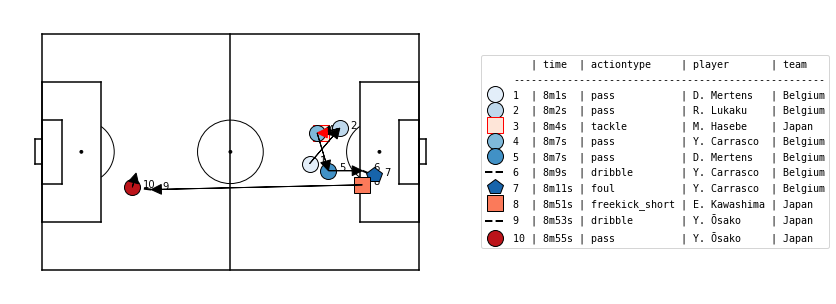

In [ ]:
action_id=145
plot_actions(df_actions[action_id:action_id+10])

In [ ]:
df_actions[action_id:action_id+2].T

,145,146
action_id,145,146
game_id,2058007.0,2058007.0
period_id,1.0,1.0
time_seconds,481.571021,482.942298
team_id,5629.0,5629.0
player_id,122.0,7905.0
start_x,74.55,82.95
start_y,30.6,40.8
end_x,82.95,77.7
end_y,40.8,39.44


## Representing locations

In [ ]:
PITCH_LENGTH=105
PITCH_WIDTH=68

GOAL_X=PITCH_LENGTH
GOAL_Y=PITCH_WIDTH/2

In [ ]:
df_actions[action_id:action_id+2][['start_x','start_y','end_x','end_y']]

,start_x,start_y,end_x,end_y
145,74.55,30.6,82.95,40.80
146,82.95,40.8,77.70,39.44


In [ ]:
for side in ['start','end']:
  key_x=f'{side}_x'
  df_actions[f'{key_x}_norm']=df_actions[key_x]/PITCH_LENGTH
  
  key_y=f'{side}_y'
  df_actions[f'{key_y}_norm']=df_actions[key_y]/PITCH_WIDTH

In [ ]:
df_actions[action_id:action_id+2][['start_x_norm','start_y_norm','end_x_norm','end_y_norm']]

,start_x_norm,start_y_norm,end_x_norm,end_y_norm
145,0.71,0.45,0.79,0.60
146,0.79,0.60,0.74,0.58


In [ ]:
for side in ['start','end']:
  diff_x=GOAL_X-df_actions[f'{side}_x']
  diff_y=abs(GOAL_Y-df_actions[f'{side}_y'])
  df_actions[f'{side}_distance_to_goal']=np.sqrt(diff_x**2+diff_y**2)
  df_actions[f'{side}_angle_to_goal']=np.divide(diff_x,diff_y,
                                                out=np.zeros_like(diff_x),
                                                where=(diff_y!=0))

In [ ]:
df_actions[action_id:action_id+1][['start_distance_to_goal','start_angle_to_goal',
                                   'end_distance_to_goal','end_angle_to_goal']]

,start_distance_to_goal,start_angle_to_goal,end_distance_to_goal,end_angle_to_goal
145,30.639231,8.955882,23.074716,3.242647


In [ ]:
for side in ['start','end']:
  df_actions[f'{side}_is_penalty_box']=((df_actions[f'{side}_x'] > (PITCH_LENGTH-16.5))&
                                        (df_actions[f'{side}_y'] > (13.85)) & 
                                        (df_actions[f'{side}_y'] > (PITCH_WIDTH-13.85)))

In [ ]:
df_actions[action_id:action_id+2][['start_is_penalty_box','end_is_penalty_box']]

,start_is_penalty_box,end_is_penalty_box
145,False,False
146,False,False


## Representing body part, action type and result

In [ ]:
pd.get_dummies(df_actions['type_name'])[:2].T

,0,1
clearance,0,0
corner_crossed,0,0
corner_short,0,0
cross,0,0
dribble,0,0
foul,0,0
freekick_crossed,0,0
freekick_short,0,0
goalkick,0,0
interception,0,0


In [ ]:
df_actions['type_name'].value_counts()

pass                977
dribble             102
interception         56
throw_in             36
clearance            36
cross                34
shot                 32
goalkick             22
foul                 22
take_on              22
freekick_short       21
corner_crossed        9
keeper_save           8
tackle                7
corner_short          6
freekick_crossed      1
shot_freekick         1
Name: type_name, dtype: int64

In [ ]:
df_actions=add_action_type_dummies(df_actions)

In [ ]:
df_actions[action_id:action_id+1].T

In [ ]:
df_actions['bodypart_name'].value_counts(), df_actions['result_name'].value_counts()

(foot     1306
 other      55
 head       31
 Name: bodypart_name, dtype: int64, success    1171
 fail        219
 offside       2
 Name: result_name, dtype: int64)

In [ ]:
df_actions[action_id:action_id+1][['bodypart_name','result_name']]

,bodypart_name,result_name
145,foot,success


## Determine distance covered in x,y and total time played

In [ ]:
add_distance_features(df_actions)
add_time_played(df_actions)

In [ ]:
df_actions[action_id:action_id+1][['diff_x','diff_y','distance_covered','time_played']]

,diff_x,diff_y,distance_covered,time_played
145,8.4,10.2,13.213629,481.571021


## Representing game states

### Representing actions leading to game state

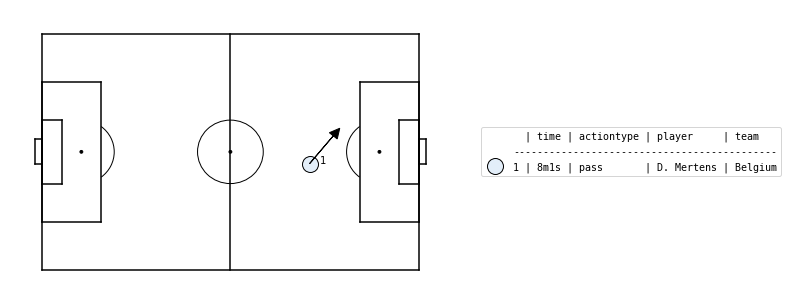

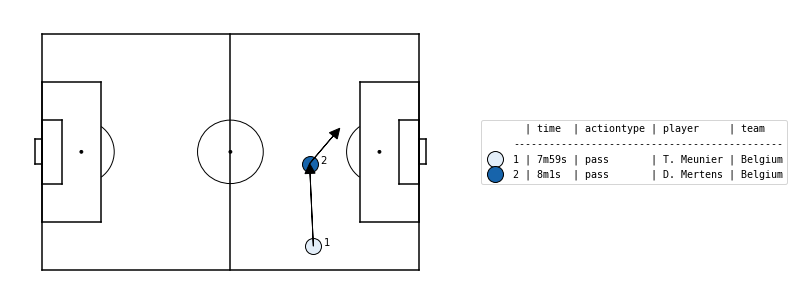

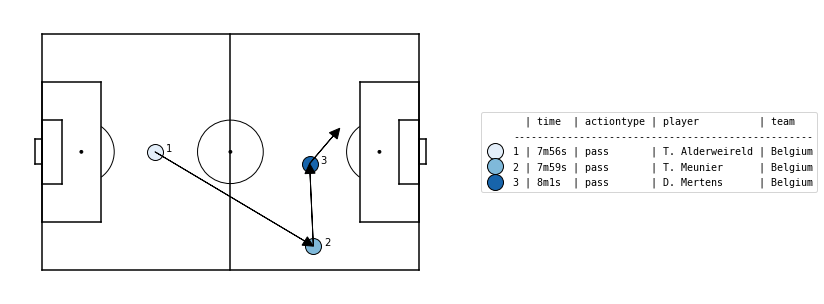

In [ ]:
for i in range(3):
  df_actions_to_plot=df_actions[145-i:146]
  plot_actions(df_actions_to_plot)

In [ ]:
delays=3
features_to_delay=['game_id', 'period_id', 'time_seconds', 'team_id',
                     'player_id', 'start_x', 'start_y', 'end_x', 'end_y', 'bodypart_id',
                     'type_id', 'result_id', 'type_name', 'result_name', 'bodypart_name',
                     'time_played']

In [ ]:
df_features=create_delayed_features(df_actions, features_to_delay, delays)

In [ ]:
location_cols=[f'{side}_{xy}-{delay}' for delay in reversed(range(0,delays))
for xy in ['x','y'] for side in ['start','end']]
df_features[action_id:action_id+1][location_cols]

,start_x-2,end_x-2,start_y-2,end_y-2,start_x-1,end_x-1,start_y-1,end_y-1,start_x-0,end_x-0,start_y-0,end_y-0
145,31.5,75.6,34.0,6.8,75.6,74.55,6.8,30.6,74.55,82.95,30.6,40.8


In [ ]:
cols=[f'{col}-{delay}' for delay in reversed(range(0,delays))
for col in ['period_id','time_seconds','type_name','bodypart_name','result_name']]
df_features[action_id:action_id+1][cols]

,period_id-2,time_seconds-2,type_name-2,bodypart_name-2,result_name-2,period_id-1,time_seconds-1,type_name-1,bodypart_name-1,result_name-1,period_id-0,time_seconds-0,type_name-0,bodypart_name-0,result_name-0
145,1.0,476.196484,pass,foot,success,1.0,479.134156,pass,foot,success,1.0,481.571021,pass,foot,success


In [ ]:
add_same_team(df_features, delays)

In [ ]:
df_features[location_cols+['team-1','team-2']].tail(10)

,start_x-2,end_x-2,start_y-2,end_y-2,start_x-1,end_x-1,start_y-1,end_y-1,start_x-0,end_x-0,start_y-0,end_y-0,team-1,team-2
1382,49.35,34.65,36.04,32.64,34.65,34.65,29.24,29.24,32.55,0.00,37.40,30.60,False,True
1383,34.65,34.65,29.24,29.24,32.55,0.00,37.40,30.60,0.00,0.00,30.60,30.60,False,True
1384,32.55,0.00,37.40,30.60,0.00,0.00,30.60,30.60,0.00,0.00,0.00,68.00,False,True
1385,0.00,0.00,30.60,30.60,0.00,0.00,0.00,68.00,13.65,30.45,29.24,22.44,False,True
1386,0.00,0.00,0.00,68.00,13.65,30.45,29.24,22.44,30.45,60.90,22.44,31.96,True,False
1387,13.65,30.45,29.24,22.44,30.45,60.90,22.44,31.96,60.90,86.10,31.96,11.56,True,True
1388,30.45,60.90,22.44,31.96,60.90,86.10,31.96,11.56,86.10,94.50,11.56,31.28,True,True
1389,60.90,86.10,31.96,11.56,86.10,94.50,11.56,31.28,94.50,95.55,31.28,39.44,True,True
1390,86.10,94.50,11.56,31.28,94.50,95.55,31.28,39.44,95.55,105.00,39.44,34.00,True,True
1391,94.50,95.55,31.28,39.44,95.55,105.00,39.44,34.00,51.45,0.00,34.00,68.00,False,False


In [ ]:
invert_coordinates(df_features, delays)

In [ ]:
df_features[location_cols+['team-1','team-2']].tail(10)

,start_x-2,end_x-2,start_y-2,end_y-2,start_x-1,end_x-1,start_y-1,end_y-1,start_x-0,end_x-0,start_y-0,end_y-0,team-1,team-2
1382,49.35,34.65,36.04,32.64,70.35,70.35,38.76,38.76,32.55,0.00,37.40,30.60,False,True
1383,34.65,34.65,29.24,29.24,72.45,105.00,30.60,37.40,0.00,0.00,30.60,30.60,False,True
1384,32.55,0.00,37.40,30.60,105.00,105.00,37.40,37.40,0.00,0.00,0.00,68.00,False,True
1385,0.00,0.00,30.60,30.60,105.00,105.00,68.00,0.00,13.65,30.45,29.24,22.44,False,True
1386,105.00,105.00,68.00,0.00,13.65,30.45,29.24,22.44,30.45,60.90,22.44,31.96,True,False
1387,13.65,30.45,29.24,22.44,30.45,60.90,22.44,31.96,60.90,86.10,31.96,11.56,True,True
1388,30.45,60.90,22.44,31.96,60.90,86.10,31.96,11.56,86.10,94.50,11.56,31.28,True,True
1389,60.90,86.10,31.96,11.56,86.10,94.50,11.56,31.28,94.50,95.55,31.28,39.44,True,True
1390,86.10,94.50,11.56,31.28,94.50,95.55,31.28,39.44,95.55,105.00,39.44,34.00,True,True
1391,10.50,9.45,36.72,28.56,9.45,0.00,28.56,34.00,51.45,0.00,34.00,68.00,False,False


In [ ]:
add_location_features(df_features, delays)

In [ ]:
df_features.head()

## Adding addtional context

In [ ]:
add_seq_per_features(df_features,delays)

In [ ]:
add_seq_post_features(df_features,delays)

In [ ]:
df_features[action_id:action_id+1]

,game_id-0,period_id-0,time_seconds-0,team_id-0,player_id-0,start_x-0,start_y-0,end_x-0,end_y-0,bodypart_id-0,...,distance_covered-2,end_x_norm-2,end_y_norm-2,end_distance_to_goal-2,end_angle_to_goal-2,xdiff_sequence_pre,ydiff_sequence_pre,time_seq_pre,xdiff_sequence_post,ydiff_sequence_post
145,2058007.0,1.0,481.571021,5629.0,122.0,74.55,30.6,82.95,40.8,0,...,51.813608,0.72,1.111765,40.052466,1.080882,43.05,-3.4,5.374537,51.45,6.8


# Generate Features and labels for a match

In [ ]:
df_labels = pd.concat([label_scores(df_actions, nr_actions=10),
                       label_concedes(df_actions, nr_actions=10)],
                      axis=1)

In [ ]:
df_labels.tail(10)

,scores,concedes
1382,False,True
1383,True,False
1384,False,True
1385,True,False
1386,True,False
1387,True,False
1388,True,False
1389,True,False
1390,True,False
1391,False,False


In [ ]:
pd.merge(df_actions[['team_name','short_name','type_name']],
         df_labels,
         left_index=True,
         right_index=True).tail(10)

,team_name,short_name,type_name,scores,concedes
1382,Japan,K. Honda,shot_freekick,False,True
1383,Belgium,T. Courtois,keeper_save,True,False
1384,Japan,K. Honda,corner_crossed,False,True
1385,Belgium,T. Courtois,pass,True,False
1386,Belgium,K. De Bruyne,dribble,True,False
1387,Belgium,K. De Bruyne,pass,True,False
1388,Belgium,T. Meunier,pass,True,False
1389,Belgium,R. Lukaku,pass,True,False
1390,Belgium,N. Chadli,shot,True,False
1391,Japan,Y. Ōsako,pass,False,False


# Generate features and labels for all matches

In [ ]:
delays=3 
features_to_delay=['game_id', 'period_id', 'time_seconds', 'team_id',
                  'player_id', 'start_x', 'start_y', 'end_x', 'end_y', 'bodypart_id',
                  'type_id', 'result_id', 'type_name', 'result_name', 'bodypart_name',
                  'time_played']
NR_ACTIONS=10

In [ ]:
df_games = pd.read_hdf('spadl.h5', key='games')
df_games.head()

,game_id,competition_id,season_id,game_date,home_team_id,away_team_id
0,2500089,364,181150,2018-05-13 14:00:00,1646,1659
1,2500090,364,181150,2018-05-13 14:00:00,1628,1627
2,2500091,364,181150,2018-05-13 14:00:00,1673,1609
3,2500092,364,181150,2018-05-13 14:00:00,1612,1651
4,2500093,364,181150,2018-05-13 14:00:00,1611,1644


In [ ]:
len(df_games)

1941

In [ ]:
for _,game in tqdm(df_games.iterrows(), total=len(df_games)):
  game_id=game['game_id']
  with pd.HDFStore('spadl.h5', mode='r') as spadl:
    df_actions=spadl[f'actions/game_{game_id}']
    df_actions=(
        df_actions.merge(spadl['actiontypes'], how='left')
        .merge(spadl['results'], how='left')
        .merge(spadl['bodyparts'], how='left')
        .reset_index(drop=True)
    )
  df_features=create_features_match(df_actions,features_to_delay,delays)
  df_features.to_hdf('features.h5',f'game_{game_id}')
  df_labels = pd.concat([label_scores(df_actions, nr_actions=NR_ACTIONS),
                       label_concedes(df_actions, nr_actions=NR_ACTIONS)],
                      axis=1)
  df_labels.to_hdf('labels.h5', f'game_{game_id}')

  0%|          | 0/1941 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:2718: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['type_name-0', 'result_name-0', 'bodypart_name-0', 'type_name-1',
       'result_name-1', 'bodypart_name-1', 'type_name-2', 'result_name-2',
       'bodypart_name-2'],
      dtype='object')]

  encoding=encoding,
100%|██████████| 1941/1941 [24:41<00:00,  1.31it/s]
